In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras import datasets, layers, models
from keras.applications import ResNet50
from keras.models import Model
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from tensorflow.keras.datasets import fashion_mnist

## **Task 1: Acquire the data**

## Fashion MNIST Data

In [ ]:
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load FashionMNIST data
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Save the unormalized images for future experiments
unormalized_X_train_fashion = X_train_fashion
unormalized_X_test_fashion = X_test_fashion
unormalized_X_train_fashion = unormalized_X_train_fashion.reshape(unormalized_X_train_fashion.shape[0],-1)
unormalized_X_test_fashion = unormalized_X_test_fashion.reshape(unormalized_X_test_fashion.shape[0],-1)

# Normalize the images
X_train_fashion = X_train_fashion.astype('float32') / 255.0
X_test_fashion = X_test_fashion.astype('float32') / 255.0

# Flatten the images
X_train_fashion = X_train_fashion.reshape((-1, 28*28))
X_test_fashion = X_test_fashion.reshape((-1, 28*28))

# One-hot encode the labels
y_train_fashion = to_categorical(y_train_fashion, 10)
y_test_fashion = to_categorical(y_test_fashion, 10)

4422102/4422102 [==============================] - 0s 0us/step


## CIFAR-10 DATA

In [ ]:
# load the CIFAR-10 data, vectorize it
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = tf.keras.datasets.cifar10.load_data()

unormalized_X_train_cifar = X_train_cifar
unormalized_X_test_cifar = X_test_cifar

# normalization to [0,1] range
X_train_cifar = X_train_cifar / 255.0
X_test_cifar = X_test_cifar /255.0

## reshape the inputs
X_train_cifar = X_train_cifar.reshape(X_train_cifar.shape[0],-1)
X_test_cifar = X_test_cifar.reshape(X_test_cifar.shape[0],-1)

#reshaping unormalized images
unormalized_X_train_cifar = unormalized_X_train_cifar.reshape(unormalized_X_train_cifar.shape[0],-1)
unormalized_X_test_cifar = unormalized_X_test_cifar.reshape(unormalized_X_test_cifar.shape[0],-1)
y_train_cifar_uncat=y_train_cifar
y_train_cifar = to_categorical(y_train_cifar)

#flatten
y_train_cifar_uncat = y_train_cifar_uncat.flatten()
y_test_cifar = y_test_cifar.flatten()

170498071/170498071 [==============================] - 2s 0us/step


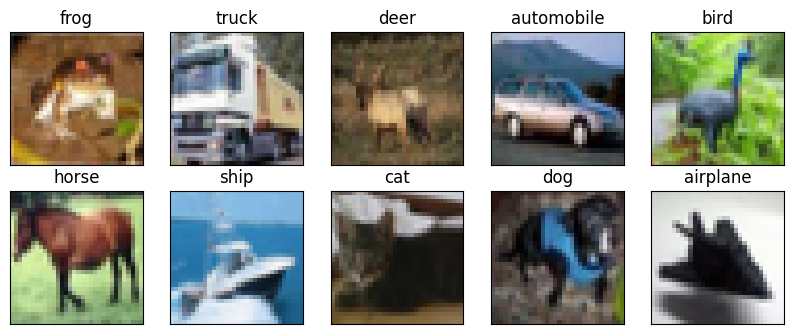

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
list_ = []
y = 0

#Show unique training images
for i in range(36):
    label_index = int(y_train_cifar_uncat[i])
    if class_names[label_index] not in list_:
      plt.subplot(5, 5, y + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(X_train_cifar[i].reshape((32, 32, 3)))
      plt.title(class_names[label_index])
      list_.append(class_names[label_index])
      y += 1
plt.show()

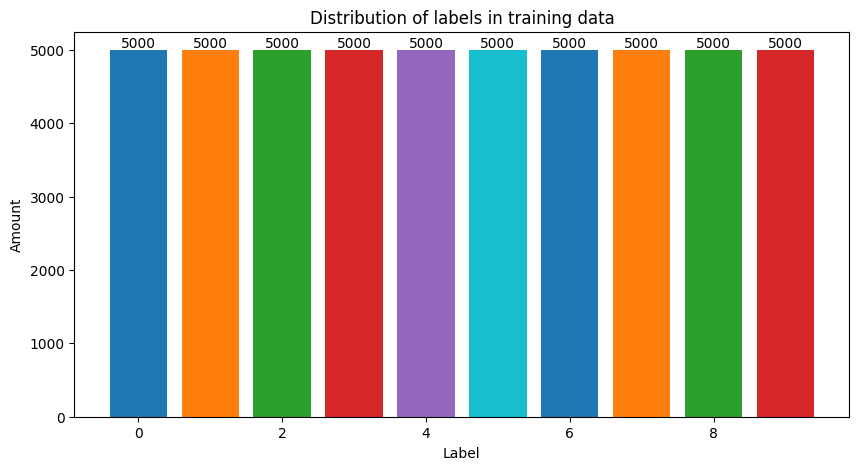

In [ ]:
#Distribution of training data class
targets, frequency = np.unique(y_train_cifar_uncat, return_counts=True)

fig=plt.figure(figsize=(10, 5))
plt.bar(targets,frequency,color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:cyan'])
plt.title('Distribution of labels in training data')
plt.xlabel('Label')
plt.ylabel('Amount')

for a,b in zip(targets, frequency):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()

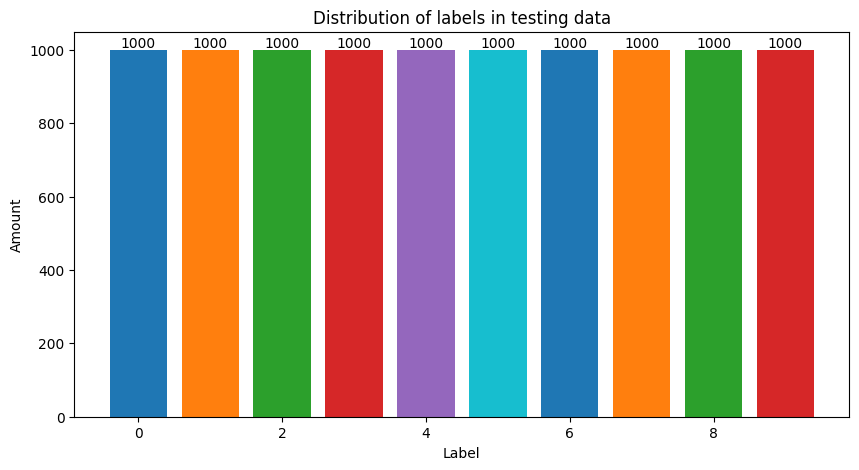

In [ ]:
#Distribution of training data class
targets, frequency = np.unique(y_test_cifar, return_counts=True)

fig=plt.figure(figsize=(10, 5))
plt.bar(targets,frequency,color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple','tab:cyan'])
plt.title('Distribution of labels in testing data')
plt.xlabel('Label')
plt.ylabel('Amount')

for a,b in zip(targets, frequency):
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

plt.show()


# **2. Implement a Multilayer Perceptron**

In [ ]:
class Cost_Cross_Entropy:
    def __init__(self, activation_fn):
        """
        Initialize the Cost_Cross_Entropy object.

        :param activation_fn: An object representing the activation function,
                              must have 'transform' and 'derivative' methods.
        """
        self.activation_fn = activation_fn
        self.gamma = None

    def __call__(self, y_true, y_pred):
        # Implement the cross-entropy calculation here
        # Ensure the prediction values are clipped to avoid log(0) error.
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        # Compute the cross-entropy.
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss

    def transform(self, x, gamma=0.01):
      self.gamma = gamma
      return self.activation_fn.transform(x,gamma = gamma)

    def loss(y_true, y_pred):
        """
        Compute the cross-entropy loss.
        :param y_true: True labels.
        :param y_pred: Predicted labels/probabilities.
        :return: Computed loss.
        """
        epsilon=1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -np.sum(y_true*np.log(y_pred+1e-9))/N
        return loss

    @staticmethod
    def derivative(Y, AL):
        """
        Derivative of the cross-entropy loss.

        :param Y: True labels.
        :param AL: Predicted labels/probabilities.
        :return: The derivative of the loss.
        """
        return AL - Y

    def delta(self, y_true, y_pred):
        """
        Compute the delta for backpropagation.

        :param y_true: True labels.
        :param y_pred: Predicted labels/probabilities.
        :return: Computed delta.
        """
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred, self.gamma)

In [ ]:
class MLP:
    def __init__(self, input_layer=3072, hidden_layer=[], output_layer=10, epochs=20, active_func=[], batch_size=200, learning_rate=0.1, gamma=0.01, l1reg = 0, l2reg = 0, weight_init = 'random'):
        self.gamma=gamma
        self.epochs=epochs
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.l1reg = l1reg
        self.l2reg = l2reg
        self.weight_init = weight_init

        self.dimensions=[input_layer]
        for h in hidden_layer:
          self.dimensions.append(h)
        self.dimensions.append(output_layer)

        self.num_layers = len(self.dimensions)
        self.weights = {}
        self.bias = {}
        self.active_func = {}

        count=0
        rng=len(active_func)
        if (rng==0):
          self.active_func[2]=Softmax
        else:
          for i in range(rng):
              count=i+2
              self.active_func[i + 2] = active_func[i]
          self.active_func[count+1]=Softmax

        self.loss = Cost_Cross_Entropy(self.active_func[self.num_layers])

        self.weight_initializations()

    def propagate(self, x):
        y_x = {}
        y_c = {1: x}
        for idx in range(1, self.num_layers):
            next_idx=idx+1
            y_x[next_idx] = self.bias[idx] + np.dot(y_c[idx], self.weights[idx])
            y_c[next_idx] = self.active_func[next_idx].transform(y_x[next_idx], self.gamma)
        return y_x, y_c

    def back_propagate(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.num_layers])
        dw = np.dot(a[self.num_layers - 1].T, delta)

        params = {
            self.num_layers - 1: (dw, delta)
        }

        for i in reversed(range(2, self.num_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.active_func[i].derivative(z[i], self.gamma)
            dw = np.dot(a[i - 1].T, delta)
            params[i - 1] = (dw, delta)

        for key, val in params.items():
            dw=val[0]
            index=key

            #l1 reg
            dw += self.l1reg * np.sign(-1 * self.weights[index])

            #l2 reg
            dw += self.l2reg * self.weights[index]

            self.weights[index] -= self.learning_rate * dw
            self.bias[index] -= self.learning_rate * np.mean(val[1], 0)

    def fit(self, X_train, y_train, return_all_loss = False):
        epoch_losses = [] #store losses for each epoch

        for i in range(self.epochs):
            #randomly select the group
            seed = np.arange(X_train.shape[0])
            np.random.shuffle(seed)
            x_ = X_train[seed]
            y_ = y_train[seed]
            iter = X_train.shape[0] // self.batch_size

            for i2 in range(iter):
                k = i2 * self.batch_size
                l = (i2 + 1) * self.batch_size
                y_x, y_c = self.propagate(x_[k:l])
                self.back_propagate(y_x, y_c, y_[k:l])

            if return_all_loss == True:
               _, a = self.propagate(X_train)
               y_pred = a[self.num_layers]
               train_loss = self.loss(y_train, y_pred)
               epoch_losses.append(train_loss)

            elif (i + 1) % 10 == 0:
               _, a = self.propagate(X_train)
               y_pred = a[self.num_layers]
               train_loss = self.loss(y_train, y_pred)
               epoch_losses.append(train_loss)
        return epoch_losses

    def predict(self, x):
        y_x, y_c = self.propagate(x)
        return np.argmax(y_c[self.num_layers],axis=1)

    def weight_initializations(self):
      rng=len(self.dimensions) - 1

      if self.weight_init == 'uniform':
        #put small random weights for each layer and divide it by the square root of input size (calibrating variance)
        for i in range(rng):
            self.weights[i + 1] = np.random.uniform(-1, 1, size = (self.dimensions[i], self.dimensions[i+1]))
            dim_sqrt = np.sqrt(self.dimensions[i])
            self.weights[i + 1]= self.weights[i + 1]/dim_sqrt
            self.bias[i + 1] = np.random.uniform(-1, 1, size = (self.dimensions[i+1]))

      elif self.weight_init == 'zeros':
        for i in range(rng):
            self.weights[i + 1] = np.zeros((self.dimensions[i], self.dimensions[i+1]))
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1])

      elif self.weight_init == 'gaussian':
        for i in range(rng):
            self.weights[i + 1] = np.random.randn(self.dimensions[i], self.dimensions[i+1])
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1]) #should these all be zeros? or

      elif self.weight_init == 'xavier':
        for i in range(rng):
            limit = np.sqrt(6 / (self.dimensions[i] + self.dimensions[i+1]))
            self.weights[i + 1] = np.random.uniform(-limit, limit, size=(self.dimensions[i], self.dimensions[i+1]))
            dim_sqrt = np.sqrt(self.dimensions[i])
            self.weights[i + 1]= self.weights[i + 1]/dim_sqrt
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1])

      elif self.weight_init == 'kaiming':
        for i in range(rng):
            std = np.sqrt(2. / self.dimensions[i])
            self.weights[i + 1] = np.random.randn(self.dimensions[i], self.dimensions[i+1]) * std
            dim_sqrt = np.sqrt(self.dimensions[i])
            self.weights[i + 1]= self.weights[i + 1]/dim_sqrt
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1])

      elif self.weight_init == "random":
        for i in range(rng):
            self.weights[i + 1] = np.random.randn(self.dimensions[i], self.dimensions[i + 1])
            dim_sqrt = np.sqrt(self.dimensions[i])
            self.weights[i + 1]= self.weights[i + 1]/dim_sqrt
            self.bias[i + 1] = np.zeros(self.dimensions[i + 1])
      else:
        raise ValueError('unknown weight initialization type')

    def calculate_training_accuracy(self, X_train, y_train):
        """
        Calculate the training accuracy of the model.

        Parameters:
        X_train (np.array): Training features.
        y_train (np.array): Training labels (one-hot encoded).

        Returns:
        float: Training accuracy.
        """
        # Forward pass on the training data
        _, activations = self.propagate(X_train)
        predictions = np.argmax(activations[self.num_layers], axis=1)
        true_labels = np.argmax(y_train, axis=1)

        # Calculate accuracy
        accuracy = self.evaluate(true_labels, predictions)
        return accuracy

    def loss(y_true, y_pred):
        """
        Compute the cross-entropy loss.

        :param y_true: True labels.
        :param y_pred: Predicted labels/probabilities.
        :return: Computed loss.
        """
        epsilon=1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -np.sum(y_true*np.log(y_pred+1e-9))/N
        return loss

    @staticmethod
    def compute_loss(y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        N = y_pred.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / N
        return loss

    def calculate_training_error(self, X_train, y_train):
        """
        Calculate the training error of the model.

        Parameters:
        X_train (np.array): Training features.
        y_train (np.array): Training labels (one-hot encoded).

        Returns:
        float: Training error.
        """
        # Forward pass on the training data
        _, activations = self.propagate(X_train)
        y_pred = activations[self.num_layers]

        # Calculate the cross-entropy loss
        training_error = self.loss.loss(y_train, y_pred)
        return training_error

    @staticmethod
    def evaluate (true_,predicted):
        predicted_shape=predicted.shape[0]
        return np.sum(true_ == predicted)/predicted_shape


In [ ]:
# Activation Functions
class Relu:
    def transform(x,gamma=0.01):
      return np.maximum(0,x)
    def derivative(d, gamma=0.01):
        mask = d <= 0
        out=d.copy()
        out[mask] = 0
        out[d>0] = 1
        return out

class Leaky_Relu:
    def transform(x, gamma=0.01):
      return np.maximum(0,x) + gamma*np.minimum(0,x)

    def derivative(d, gamma=0.01):
        mask = d <= 0
        out=d.copy()
        out[mask] = gamma
        out[d>0] = 1
        return out

class Sigmoid:
    def transform(x,gamma=0.01):
        return 1 / (1 + np.exp(-x))
    def derivative(d, gamma=0.01):
        d_transformed = 1 / (1 + np.exp(-d))
        return d_transformed * (1 - d_transformed)

class Tanh:
    def transform(x,gamma=0.01):
      return np.tanh(x)

    def derivative(d, gamma=0.01):
      transformed = Tanh.transform(d,gamma=0.01)
      return 1 - transformed**2

class Softmax:
    def transform(x,gamma=0.01):
      exp_ = x-np.max(x)
      nx = np.exp(exp_)
      sum = np.sum(nx, axis=1, keepdims=True)
      return nx/sum

    def derivative(d,gamma=0.01):
        return Softmax.transform(d,gamma=0.01)*Softmax.transform(1-d,gamma=0.01)

# **3. Run Experiments**

In [ ]:
def plot_training_losses(all_train_losses, all_test_losses):
  # Plotting the training losses
  for i, rate in enumerate(lre):
      plt.plot(all_train_losses[i], label=f'LR={rate}')

  plt.title('Training Loss per Epoch for Different Learning Rates')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.legend()
  plt.show()

  # Plotting the test losses
  for i, rate in enumerate(lr):
      plt.plot(all_test_losses[i], label=f'LR={rate}')

  plt.title('Test Loss per Epoch for Different Learning Rates')
  plt.xlabel('Epoch')
  plt.ylabel('Test Loss')
  plt.legend()
  plt.show()

##### Epoch Test

Running epoch: 1
Train Accuracy: 57.82%
Test Accuracy: 0.5767

Running epoch: 10
Train Accuracy: 81.54%
Test Accuracy: 0.806

Running epoch: 25
Train Accuracy: 85.61%
Test Accuracy: 0.8391

Running epoch: 50
Train Accuracy: 87.80%
Test Accuracy: 0.8559

Running epoch: 100
Train Accuracy: 88.18%
Test Accuracy: 0.851

Running epoch: 200
Train Accuracy: 88.51%
Test Accuracy: 0.8472



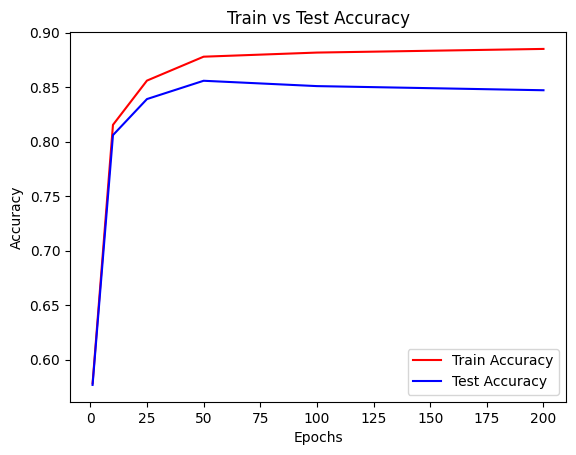

In [ ]:
epoch_num = [1, 10, 25, 50, 100, 200]
train_accuracies = []
test_accuracies = []

mlp = MLP(input_layer=28*28,   # Since each image is 28x28 pixels, flattened
        hidden_layer=[128, 64],  # Example: Two hidden layers with 128 and 64 neurons
        output_layer=10,     # 10 classes in FashionMNIST
        # epochs=300,           # Example: Number of epochs
        active_func=[Relu, Relu], # Activation functions for the hidden layers
        batch_size=200,      # Batch size for training
        learning_rate=0.005,     # Learning rate
        gamma=0.01,          # Gamma parameter for activation functions
        l1reg=0.001,         # L1 regularization
        l2reg=0.001,         # L2 regularization
        weight_init = 'uniform')


for epoch in epoch_num:
  print("Running epoch:", epoch)
  mlp.epochs = epoch
  mlp.fit(X_train_fashion, y_train_fashion)
  train_acc = mlp.calculate_training_accuracy(X_train_fashion, y_train_fashion)
  print(f"Train Accuracy: {train_acc * 100:.2f}%")
  train_accuracies.append(train_acc)

  y_pred = mlp.predict(X_test_fashion)
  y_test_labels = np.argmax(y_test_fashion, axis=1)
  test_acc = MLP.evaluate(y_test_labels, y_pred)
  test_accuracies.append(test_acc)
  print("Test Accuracy:", test_acc)
  print()


# Plot train and test accuracies for different epochs of the same model
fig, ax = plt.subplots()

ax.plot(epoch_num, train_accuracies, color='r', label='Train Accuracy')
ax.plot(epoch_num, test_accuracies, color='b', label='Test Accuracy')

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Train vs Test Accuracy")

ax.legend()
plt.show()

we found the best number of epoch is 50.

##### Learning Rate Test

In [ ]:
lr = [0.0005, 0.001, 0.005, 0.01, 0.05]
learning_rate_train_accuracies = []
learning_rate_test_accuracies = []


mlp = MLP(input_layer=28*28,   # Since each image is 28x28 pixels, flattened
        hidden_layer=[128, 64],  # Example: Two hidden layers with 128 and 64 neurons
        output_layer=10,     # 10 classes in FashionMNIST
        epochs=50,           # Example: Number of epochs
        active_func=[Relu, Relu], # Activation functions for the hidden layers
        batch_size=200,      # Batch size for training
        gamma=0.01,          # Gamma parameter for activation functions
        l1reg=0.001,         # L1 regularization
        l2reg=0.001,         # L2 regularization
        weight_init = 'uniform')

for i in lr:
  train_losses = []
  test_losses = []

  print("Current Learning rate:", i)
  mlp.learning_rate = i
  mlp.fit(X_train_fashion, y_train_fashion)
  train_acc = mlp.calculate_training_accuracy(X_train_fashion, y_train_fashion)
  print(f"Train Accuracy: {train_acc * 100:.2f}%")
  learning_rate_train_accuracies.append(train_acc)

  y_pred = mlp.predict(X_test_fashion)
  y_test_labels = np.argmax(y_test_fashion, axis=1)
  test_acc = MLP.evaluate(y_test_labels, y_pred)
  learning_rate_test_accuracies.append(test_acc)
  print("Test Accuracy:", test_acc)
  print()

Current Learning rate: 0.0005
Train Accuracy: 75.92%
Test Accuracy: 0.754

Current Learning rate: 0.001
Train Accuracy: 82.98%
Test Accuracy: 0.8178

Current Learning rate: 0.005
Train Accuracy: 87.33%
Test Accuracy: 0.8591

Current Learning rate: 0.01
Train Accuracy: 88.23%
Test Accuracy: 0.853

Current Learning rate: 0.05
Train Accuracy: 85.17%
Test Accuracy: 0.8114



In [ ]:
print(learning_rate_train_accuracies)

[0.75925, 0.8297666666666667, 0.8733, 0.8822666666666666, 0.85175]


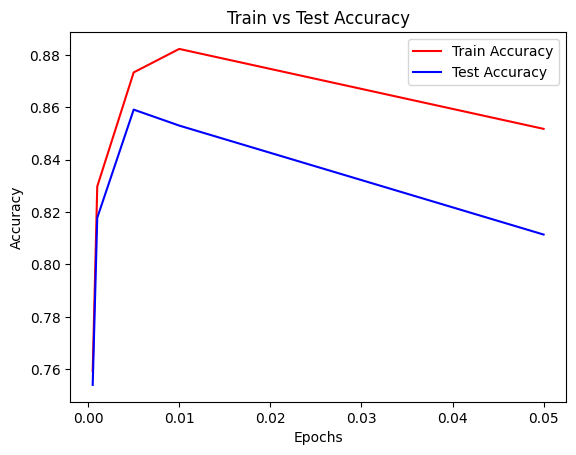

In [ ]:
# Plot train and test accuracies for different epochs of the same model
fig, ax = plt.subplots()

ax.plot(lr, learning_rate_train_accuracies, color='r', label='Train Accuracy')
ax.plot(lr, learning_rate_test_accuracies, color='b', label='Test Accuracy')

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Train vs Test Accuracy")

ax.legend()
plt.show()

## Task 1: Effects of weight-initialization methods on model performance


[2.3025850929940455, 2.3025850929940455, 2.302585092994046, 2.3025850929940455, 2.3025850929940455, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.3025850929940463, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.3025850929940463, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.3025850929940463, 2.302585092994046, 2.302585092994046, 2.302585092994046, 2.302585092994047, 2.3025850929940463, 2.3025850929940463, 2.302585092994047, 2.302585092994046, 2.3025850929940463, 2.3025850929940463, 2.3025850929940463, 2.3025850929940463, 2.302585092994046, 2.302585092994046, 2.3025850929940463, 2.3025850929940463, 2.3025850929940463, 2.302585092994047, 2.302585092994047, 2.3025850929940463, 2.302585092994047, 2.302585092994047, 2.302585092994047, 2.3025850929940463, 2.302585092994047, 2.302585092994047, 2.302585092994047, 2.3025850929940463, 2.302585092994047, 2.3025850929940463]


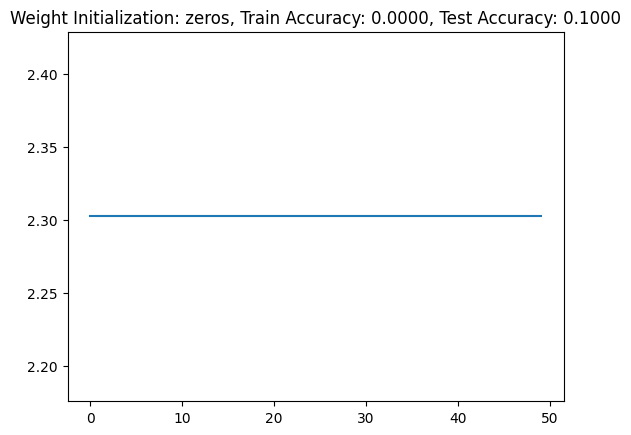

In [ ]:
# Function to train and evaluate an MLP model
def train_and_evaluate_mlp(weight_init):
    mlp = MLP(input_layer=28*28,
              hidden_layer=[128],
              output_layer=10,
              epochs=50,
              active_func=[Relu],
              batch_size=200,
              learning_rate=0.005,
              gamma=0.01,
              l1reg=0.001,
              l2reg=0.001,
              weight_init=weight_init)
    losses = mlp.fit(X_train_fashion, y_train_fashion, return_all_loss = True)
    print(losses)

    predictions_test = mlp.predict(X_test_fashion)
    accuracy_test = mlp.evaluate(np.argmax(y_test_fashion, axis=1), predictions_test)
    predictions_train = mlp.predict(X_train_fashion)
    accuracy_train = mlp.evaluate(np.argmax(X_train_fashion, axis=1), predictions_train)
    #print(f"Weight Initialization: {weight_init}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")
    plt.plot(losses)
    plt.title(f"Weight Initialization: {weight_init}, Train Accuracy: {accuracy_train:.4f}, Test Accuracy: {accuracy_test:.4f}")
    plt.show()

# Different types of weight initializations
weight_inits = ['zeros', 'uniform', 'gaussian', 'xavier', 'kaiming']

for init in weight_inits:
    train_and_evaluate_mlp(init)

In [ ]:
# Function to train and evaluate an MLP model
def train_and_evaluate_mlp(weight_init):
    mlp = MLP(input_layer=28*28,
              hidden_layer=[128],
              output_layer=10,
              epochs=50,
              active_func=[Relu],
              batch_size=200,
              learning_rate=0.005,
              gamma=0.01,
              l1reg=0.001,
              l2reg=0.001,
              weight_init=weight_init)
    mlp.fit(X_train_fashion, y_train_fashion)

    predictions = mlp.predict(X_test_fashion)
    accuracy = mlp.evaluate(np.argmax(y_test, axis=1), predictions)
    print(f"Weight Initialization: {weight_init}, Test Accuracy: {accuracy:.4f}")

# Different types of weight initializations
weight_inits = ['zeros', 'uniform', 'gaussian', 'xavier', 'kaiming']

for init in weight_inits:
    train_and_evaluate_mlp(init)

## Task 2: Effects of neural network depth on model performance

In [ ]:
# models

model_1 = MLP(input_layer=28*28,
              hidden_layer=[],
              output_layer=10,
              epochs=50,
              learning_rate=0.005,
              weight_init='uniform')

# epochs -> 10
# learning rate --> 0.001 - 0.01, using 0.05 right now
model_2 = MLP(input_layer=28*28,
              hidden_layer=[128],
              output_layer=10,
              epochs=50,
              learning_rate=0.005,
              active_func = [Relu],
              weight_init='uniform')

model_3 = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=50,
              learning_rate=0.005,
              active_func = [Relu, Relu],
              weight_init='uniform')

In [ ]:
# Train the models
models = [model_1, model_2, model_3]
for model in models:
    model.fit(X_train_fashion, y_train_fashion)

In [ ]:
# Evaluate the models
accuracies = []
for model in models:
    y_pred = model.predict(X_test_fashion)
    y_test_labels = np.argmax(y_test_fashion, axis=1)
    accuracy = MLP.evaluate(y_test_labels, y_pred)
    accuracies.append(accuracy)

In [ ]:
# Print the accuracies
print("Model 1 Accuracy:", accuracies[0])
print("Model 2 Accuracy:", accuracies[1])
print("Model 3 Accuracy:", accuracies[2])

Model 1 Accuracy: 0.8246
Model 2 Accuracy: 0.844
Model 3 Accuracy: 0.8494


## Task 3: Effect of Different Activation Functions

In [28]:
# Initiate the models
model_Relu = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=100,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              weight_init='uniform')

model_Leaky_Relu = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=100,
              learning_rate=0.01,
              active_func = [Leaky_Relu, Leaky_Relu],
              weight_init='uniform')

model_Sigmoid = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=100,
              learning_rate=0.01,
              active_func = [Sigmoid, Sigmoid],
              weight_init='uniform')

In [29]:
# Train the models
models = [model_Relu, model_Leaky_Relu, model_Sigmoid]
for model in models:
    model.fit(X_train_fashion, y_train_fashion)

In [30]:
# Evaluate the models
accuracies = []
for model in models:
    y_pred = model.predict(X_test_fashion)
    y_test_labels = np.argmax(y_test_fashion, axis=1)
    accuracy = MLP.evaluate(y_test_labels, y_pred)
    accuracies.append(accuracy)

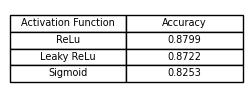

In [41]:
# Show results in a table
activation_function = ["ReLu", "Leaky ReLu", "Sigmoid"]

fig, ax = plt.subplots(figsize=(3, 1))

ax.axis('off')

table_data = list(zip(activation_function, accuracies))
columns = ["Activation Function", "Accuracy"]
ax.table(cellText=table_data, colLabels=columns, cellLoc = 'center', loc='center')

plt.show()

## Task 4: Effect of Different Regularization Strengths

#### Fashion MNIST



In [42]:
# Initialize lambdas
lambdas_ = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]

In [44]:
# L1 regularization
L1_accuracies = []
for lambda_ in lambdas_:
  print("With lambda: " + str(lambda_))
  model_L1 = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=20,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              l1reg = lambda_,
              weight_init='uniform')
  model_L1.fit(X_train_fashion, y_train_fashion)
  y_pred = model_L1.predict(X_test_fashion)
  y_test_labels = np.argmax(y_test_fashion, axis=1)
  accuracy = MLP.evaluate(y_test_labels, y_pred)
  print("accuracy:", accuracy)
  L1_accuracies.append(accuracy)

With lambda: 1e-07
accuracy: 0.8439
With lambda: 1e-06
accuracy: 0.8407
With lambda: 1e-05
accuracy: 0.8446
With lambda: 0.0001
accuracy: 0.8414
With lambda: 0.001
accuracy: 0.8485
With lambda: 0.01
accuracy: 0.781


In [45]:
# L2 regularization
L2_accuracies = []
for lambda_ in lambdas_:
  print("With lambda: " + str(lambda_))
  model_L2 = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=20,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              l2reg = lambda_,
              weight_init='uniform')
  model_L2.fit(X_train_fashion, y_train_fashion)
  y_pred = model_L2.predict(X_test_fashion)
  y_test_labels = np.argmax(y_test_fashion, axis=1)
  accuracy = MLP.evaluate(y_test_labels, y_pred)
  print("accuracy:", accuracy)
  L2_accuracies.append(accuracy)

With lambda: 1e-07
accuracy: 0.8299
With lambda: 1e-06
accuracy: 0.8445
With lambda: 1e-05
accuracy: 0.8412
With lambda: 0.0001
accuracy: 0.8426
With lambda: 0.001
accuracy: 0.8419
With lambda: 0.01
accuracy: 0.8219


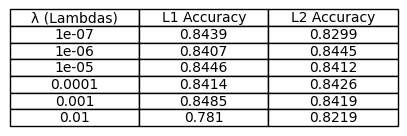

In [46]:
# Show results in a table
fig, ax = plt.subplots(figsize=(5, 1.5))

ax.axis('off')

table_data = list(zip(lambdas_, L1_accuracies, L2_accuracies))
columns = ["λ (Lambdas)", "L1 Accuracy", "L2 Accuracy"]
ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center')

plt.show()

#### CIFAR-10

In [47]:
# Initialize lambdas
lambdas_ = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]

In [48]:
# L1 regularization
L1_accuracies = []
for lambda_ in lambdas_:
  print("With lambda: " + str(lambda_))
  model_L1 = MLP(input_layer=32*32*3,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=20,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              l1reg = lambda_,
              weight_init='uniform')
  model_L1.fit(X_train_cifar, y_train_cifar)
  y_pred = model_L1.predict(X_test_cifar)
  accuracy = MLP.evaluate(y_test_cifar, y_pred)
  print("accuracy:", accuracy)
  L1_accuracies.append(accuracy)

With lambda: 1e-07
accuracy: 0.4627
With lambda: 1e-06
accuracy: 0.4671
With lambda: 1e-05
accuracy: 0.4492
With lambda: 0.0001
accuracy: 0.4666
With lambda: 0.001
accuracy: 0.4369
With lambda: 0.01
accuracy: 0.3128


In [49]:
# L2 regularization
L2_accuracies = []
for lambda_ in lambdas_:
  print("With lambda: " + str(lambda_))
  model_L2 = MLP(input_layer=32*32*3,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=20,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              l2reg = lambda_,
              weight_init='uniform')
  model_L2.fit(X_train_cifar, y_train_cifar)
  y_pred = model_L2.predict(X_test_cifar)
  accuracy = MLP.evaluate(y_test_cifar, y_pred)
  print("accuracy:", accuracy)
  L2_accuracies.append(accuracy)

With lambda: 1e-07
accuracy: 0.4562
With lambda: 1e-06
accuracy: 0.4744
With lambda: 1e-05
accuracy: 0.4517
With lambda: 0.0001
accuracy: 0.4616
With lambda: 0.001
accuracy: 0.4612
With lambda: 0.01
accuracy: 0.4427


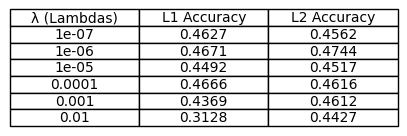

In [50]:
# Show results in a table
fig, ax = plt.subplots(figsize=(5, 1.5))

ax.axis('off')

table_data = list(zip(lambdas_, L1_accuracies, L2_accuracies))
columns = ["λ (Lambdas)", "L1 Accuracy", "L2 Accuracy"]
ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center')

plt.show()

## Task 5: Effect of Input Normalization on Model Accuracy

#### Fashion Dataset

In [51]:
# Unormalized
model_fashion_unormalized = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=20,
              learning_rate=0.001,
              active_func = [Relu, Relu],
              weight_init='uniform')

model_fashion_unormalized.fit(unormalized_X_train_fashion, y_train_fashion)

y_pred = model_fashion_unormalized.predict(unormalized_X_test_fashion)
y_test_labels = np.argmax(y_test_fashion, axis=1)
accuracy = MLP.evaluate(y_test_labels, y_pred)
print("Unormalized Accuracy: ", accuracy)

# Normalized
model_fashion_normalized = MLP(input_layer=28*28,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=20,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              weight_init='uniform')
model_fashion_normalized.fit(X_train_fashion, y_train_fashion)

y_pred = model_fashion_normalized.predict(X_test_fashion)
y_test_labels = np.argmax(y_test_fashion, axis=1)
accuracy = MLP.evaluate(y_test_labels, y_pred)
print("Normalized Accuracy: ", accuracy)

Unormalized Accuracy:  0.864
Normalized Accuracy:  0.8379


#### CIFAR-10 dataset


In [52]:
# Unormalized
model_cifar_unormalized = MLP(input_layer=32*32*3,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=30,
              learning_rate=0.0001,
              active_func = [Relu, Relu],
              weight_init='uniform')
model_cifar_unormalized.fit(unormalized_X_train_cifar, y_train_cifar)

y_pred = model_cifar_unormalized.predict(unormalized_X_test_cifar)
accuracy = MLP.evaluate(y_test_cifar, y_pred)
print("Unormalized Accuracy: ", accuracy)

# Normalized
model_cifar_normalized = MLP(input_layer=32*32*3,
              hidden_layer=[128, 128],
              output_layer=10,
              epochs=30,
              learning_rate=0.01,
              active_func = [Relu, Relu],
              weight_init='uniform')
model_cifar_normalized.fit(X_train_cifar, y_train_cifar)

y_pred = model_cifar_normalized.predict(X_test_cifar)
accuracy = MLP.evaluate(y_test_cifar, y_pred)
print("Normalized Accuracy: ", accuracy)

Unormalized Accuracy:  0.4109
Normalized Accuracy:  0.4844


## Task 6/7/8 (CNN)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, kernel_size, padding, input_size, hidden_size, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=middle_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=middle_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding)
        self.pool = nn.MaxPool2d(2)
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.hidden_layer(x))
        out = F.relu(self.output_layer(x))
        return out

    def evaluate_acc(self, loader):
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)

                outputs = self.forward(images)
                predicted = torch.argmax(outputs.data, dim=1)

                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        return 100*correct/total

def train(model, optimizer, loss_func, n_epochs):
  losses = []
  test_accs = []
  for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # Iterate over data
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Move tensor to the same device (CPU/GPU) as the model
      images, labels = images.to(device), labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward + loss calc + backward + step
      outputs = model(images)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        test_acc = model.evaluate_acc(test_loader)
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}, Test Accuracy: {test_acc:.2f}%")

      losses.append(loss.item())
      epoch_acc.append(test_acc)
    test_accs.append(np.mean(epoch_acc))
  return losses, test_accs

## Task 6 : CNN on FashionMNIST

In [ ]:
from torchvision import datasets, transforms
# Load the built-in dataset MNIST
train_dataset = datasets.FashionMNIST(root='./data',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True)

test_dataset = datasets.FashionMNIST(root='./data',
                     train=False,
                     transform=transforms.ToTensor())

batch_size = 100

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(1, 16, 32, 5, 2, 32*7*7, 128, 10)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
losses, test_accs = train(model, optimizer, loss_func, n_epochs=20)
final_train_acc = model.evaluate_acc(train_loader)
final_test_acc = model.evaluate_acc(test_loader)
print(f"Final Train Accuracy: {final_train_acc:.2f}%, Final Test Accuracy: {final_test_acc:.2f}%")
plt.plot(np.arange(len(losses)), losses, 'r')
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close()
plt.plot(np.arange(len(test_accs)), test_accs, 'r')
plt.title('Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
plt.close()

## Task 7 : CNN on CIFAR-10

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Load the built-in dataset MNIST
train_dataset = datasets.CIFAR10(root='./data',
                      train=True,
                      transform=transforms.ToTensor(),
                      download=True)

test_dataset = datasets.CIFAR10(root='./data',
                     train=False,
                     transform=transforms.ToTensor())

batch_size = 100

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(3, 32, 64, 4, 1, 64*7*7, 128, 10)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum = 0.9)
losses, test_accs = train(model, optimizer, loss_func, n_epochs=30)
final_train_acc = model.evaluate_acc(train_loader)
final_test_acc = model.evaluate_acc(test_loader)
print(f"Final Train Accuracy: {final_train_acc:.2f}%, Final Test Accuracy: {final_test_acc:.2f}%")
plt.plot(np.arange(len(losses)), losses, 'r')
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close()
plt.plot(np.arange(len(test_accs)), test_accs, 'r')
plt.title('Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
plt.close()

## Task 8 : CNN with multiple Momentum and Adam Optimizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
momentum = [0, 0.25, 0.5, 0.75, 0.9, 0.95]
for m in momentum:
  print(f"For Momentum = {m}:")
  model = CNN(3, 32, 64, 4, 1, 64*7*7, 128, 10)
  model.to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum = m)
  losses, test_accs = train(model, optimizer, loss_func, n_epochs=15)
  final_train_acc = model.evaluate_acc(train_loader)
  final_test_acc = model.evaluate_acc(test_loader)
  print(f"Final Train Accuracy: {final_train_acc:.2f}%, Final Test Accuracy: {final_test_acc:.2f}%")
  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  plt.close()
  plt.plot(np.arange(len(test_accs)), test_accs, 'r')
  plt.title('Test Accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.show()
  plt.close()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_list = [0.01, 0.005, 0.001, 0.0005, 0.0001]
for lr in lr_list:
  print(f"For lr = {lr}:")
  model = CNN(3, 32, 64, 4, 1, 64*7*7, 128, 10)
  model.to(device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  losses, test_accs = train(model, optimizer, loss_func, n_epochs=15)
  final_train_acc = model.evaluate_acc(train_loader)
  final_test_acc = model.evaluate_acc(test_loader)
  print(f"Final Train Accuracy: {final_train_acc:.2f}%, Final Test Accuracy: {final_test_acc:.2f}%")
  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  plt.close()
  plt.plot(np.arange(len(test_accs)), test_accs, 'r')
  plt.title('Test Accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.show()
  plt.close()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(3, 32, 64, 4, 1, 64*7*7, 128, 10)
model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses, test_accs = train(model, optimizer, loss_func, n_epochs=30)
final_train_acc = model.evaluate_acc(train_loader)
final_test_acc = model.evaluate_acc(test_loader)
print(f"Final Train Accuracy: {final_train_acc:.2f}%, Final Test Accuracy: {final_test_acc:.2f}%")
plt.plot(np.arange(len(losses)), losses, 'r')
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close()
plt.plot(np.arange(len(test_accs)), test_accs, 'r')
plt.title('Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
plt.close()